**Instituto de Informática - UFG**

Disciplina: Inteligência Artificial

Prof. Cedric Luiz de Carvalho

Grupo número (   )

---


Aluna(o): 

---

Aluna(o): 

---

Aluna(o): 

---

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import math
from collections import defaultdict
df = pd.read_csv('baseDeDados.csv', sep=';')

/home/user/.conda/envs/tcc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dado que:

"Um aluno com bom desempenho é aquele que se forma em até 4 anos e meio ou se forma com média igual ou superior a 7 ou se forma com número de reprovações igual inferior a 5."

Temos:

\begin{equation*}
A \lor ( B \land C ) \lor ( B \land D )
\end{equation*}

Sendo:

**A:** O aluno se forma em 4 anos e meio.

**B:** O aluno se formou. 

**C:** O aluno tem média igual ou superior a 7.

**D:** O aluno tem número de reprovações igual ou inferior a 5.

Serão desconsiderados alunos que ingressaram há menos de 4 anos e meio atrás ( depois de 2015.1 ).

O campo "media_global_atual_discente" contém valores NaN. Iremos tratar este campo considerando uma média global calculada nas posições onde este campo apresenta NaN.

In [2]:
alunos = df[['id', \
             'ano_periodo_ingresso', \
             'data_colacao_grau', \
             'media_global_atual_discente']]\
.rename(columns={'id': 'identificador'})

media_global = df[['id', \
                   'nota_discente_componente']]\
.rename(columns={'id': 'identificador'})\
.dropna()\
.groupby(by=['identificador'])\
.mean()\
.rename(columns={'nota_discente_componente': 'media_global_calculada'})

alunos = pd.merge(alunos, \
                  media_global, \
                  how='outer', \
                  on='identificador')

alunos['media_global_considerada'] = alunos['media_global_atual_discente'].\
combine(alunos['media_global_calculada'], lambda x,y: x if not math.isnan(x) else y )

Vamos contar a quantidade de reprovações de cada aluno.

In [3]:
alunos['reprovacoes'] = 0

cols = ['quantidade_reprovacoes_nc', \
        'quantidade_reprovacoes_nl', \
        'quantidade_reprovacoes_neobr', \
        'quantidade_reprovacoes_neopt']

for item in cols:
     alunos['reprovacoes'] += df[item].fillna(0)

Iremos desconsiderar alunos que ingressaram há menos de 4 anos e meio atrás: depois de 2015.1.

In [4]:
alunos = alunos[alunos['ano_periodo_ingresso'] < 2015.1 ]

Agora iremos calcular a expressão \begin{equation*} A \lor ( B \land C ) \lor ( B \land D ) \end{equation*} e armazenar o valor no campo **classificacao_final**.

In [5]:
alunos['classificacao_1'] = 0
alunos['classificacao_2'] = 0
alunos['classificacao_3'] = 0
alunos['classificacao_final'] = 0

# Se forma em até quatro anos e meio

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].fillna('0-0-0')

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].\
apply(lambda x: int(x.split('-')[0]) + 0.1 * (int(x.split('-')[1]) < 7) + 0.2 * (int(x.split('-')[1]) > 7)  )

alunos['diff'] = alunos['data_colacao_grau'] - alunos['ano_periodo_ingresso']

alunos['classificacao_1'] = alunos['diff'].\
apply(lambda x: 1 if ( x <= 4.5 and x > 0 ) else 0)

alunos = alunos.drop_duplicates()

# se forma

alunos['formado'] = alunos['diff'].\
apply(lambda x: 1 if x > 0 else 0)

# "se forma E tem média igual ou superior a 7"

alunos['classificacao_2'] = alunos['media_global_considerada'].\
apply(lambda x: 1 if x >= 7 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# "se forma E tem número de reprovações igual inferior a 5."

alunos['classificacao_3'] = alunos['reprovacoes'].\
apply(lambda x: 1 if x <= 5 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# classificacao final

alunos['classificacao_final'] = alunos['classificacao_1'].\
combine(alunos['classificacao_2'], lambda x,y: 1 if x | y else 0 ).\
combine(alunos['classificacao_3'], lambda x,y: 1 if x | y else 0 )

alunos.sample(10)

,identificador,ano_periodo_ingresso,data_colacao_grau,media_global_atual_discente,media_global_calculada,media_global_considerada,reprovacoes,classificacao_1,classificacao_2,classificacao_3,classificacao_final,diff,formado
1792,47,2008.1,2015.2,4.95,4.901429,4.950000,31.0,0,0,0,0,7.1,1
6661,186,2010.2,2016.1,6.03,5.985185,6.030000,14.0,0,0,0,0,5.9,1
9778,284,2011.1,2018.2,5.11,5.134722,5.110000,34.0,0,0,0,0,7.1,1
1871,49,2009.1,2014.1,NaN,8.002326,8.002326,1.0,0,1,1,1,5.0,1
8983,258,2011.2,0.1,3.68,3.853846,3.680000,24.0,0,0,0,0,-2011.1,0
11884,342,2012.1,2016.2,6.93,6.936957,6.930000,4.0,1,0,1,1,4.1,1
18483,546,2014.1,0.1,5.07,5.373077,5.070000,17.0,0,0,0,0,-2014.0,0
14625,420,2013.1,0.1,NaN,1.475000,1.475000,5.0,0,0,0,0,-2013.0,0
4124,108,2009.1,2014.1,NaN,8.204444,8.204444,4.0,0,1,1,1,5.0,1
8391,235,2011.1,0.1,NaN,5.050000,5.050000,2.0,0,0,0,0,-2011.0,0


Iremos descartar do treinamento as disciplinas que não pertencem aos dois primeiros períodos.

In [6]:
disciplinas = df[['matriz_semestre_previsto_cursar_compomente', 'nome_componente']].\
drop_duplicates().\
rename(columns={'matriz_semestre_previsto_cursar_compomente': 'semestre_previsto'})

disciplinas['num_semestre'] = disciplinas['semestre_previsto'].\
apply(lambda x: int(x.split('/')[1][0]) )

disciplinas = disciplinas[disciplinas['num_semestre'] <= 2]

# somente da grade antiga
disciplinas = disciplinas[disciplinas['semestre_previsto'].str.contains('CICOMP-BI-2')]

disciplinas

,semestre_previsto,nome_componente,num_semestre
0,CICOMP-BI-2/1-IME0073,CÁLCULO 1,1
1,CICOMP-BI-2/1-INF0131,LÓGICA MATEMÁTICA,1
2,CICOMP-BI-2/1-INF0135,MATEMÁTICA DISCRETA,1
3,CICOMP-BI-2/2-IFI0105,FÍSICA PARA COMPUTAÇÃO,2
4,CICOMP-BI-2/2-IME0006,ÁLGEBRA LINEAR,2
6,CICOMP-BI-2/2-IME0078,CÁLCULO 2,2
7,CICOMP-BI-2/2-INF0157,PROGRAMAÇÃO DE COMPUTADORES 2 CN,2
8,CICOMP-BI-2/2-INF0195,SISTEMAS DIGITAIS,2
58,CICOMP-BI-2/1-INF0109,INTRODUÇÃO À COMPUTAÇÃO,1
60,CICOMP-BI-2/1-INF0156,PROGRAMAÇÃO DE COMPUTADORES 1 CN,1


Observaremos a nota de cada aluno na n-ésima tentativa de passar na disciplina.

In [7]:
disciplinas = disciplinas[['nome_componente']]

identificadores = alunos[['identificador']]
notas = pd.merge(df[['id', 'nome_componente', 'nota_discente_componente']].\
                       rename(columns={'id': 'identificador'}),\
                       identificadores, how='outer', on='identificador')

# enumerar linhas repetidas

notas['componente_enum'] = notas[['identificador', 'nome_componente']].\
groupby(by=['identificador', 'nome_componente']).\
cumcount()+1

# Atribuição de Valores a pares aluno/matéria

Seja "bom aluno" o aluno que possui bom desempenho.

Considere um aluno qualquer $a$ e uma matéria $m$.

A este par ($a$, $m$) iremos atribuir dois valores:

**Primeiro valor** ($X_{a,m}$), campo **porcentagem_minima**: 

Seja $f(a,m)$ uma função que retorna a quantidade de tentativas que o aluno $a$ realizou para passar na matéria $m$.

Seja $T_{m,n}$ a quantidade de bons alunos que passaram na matéria $m$ na $n$-ésima tentativa, e $U_m$ a quantidade total de bons alunos que já cursaram a matéria $m$.
Então:

$$X_{a,m} = \frac{T_{m,z}}{U_m}$$

sendo $z = f(a,m)$.

**Segundo valor** ($Y_{a,m}$), campo **media_ponderada**:

Seja $M_{m,n}$ a média geral dos bons alunos que cursaram a matéria $m$ por $n$ vezes.

Seja $N_{a,n}$ a nota do aluno $a$ na $n$-ésima tentativa de passar na matéria.

Então:
\begin{equation*}
Y_{a,m} = \frac{\sum_{i=1}^{f(a,m)} T_{m,i} * D_{a,m,i} }{\sum_{i=1}^{f(a,m)} T_{m,i}}
\end{equation*}

Sendo: $$D_{a,m,n} = \frac{( N_{a,n} - M_{m,n} ) + 10}{20}$$

In [8]:
identificadores = alunos[['identificador', 'classificacao_final']]
identificadores = identificadores[identificadores['classificacao_final'] == 1][['identificador']]


medias = notas[['identificador','nome_componente','nota_discente_componente','componente_enum']]

medias = \
pd.merge(identificadores, notas, how='outer', on='identificador').\
groupby(by=['nome_componente', 'componente_enum']).\
mean().\
reset_index([0,-1]).\
rename(columns={'nota_discente_componente' : 'media'})

# Qual porcentagem de bons alunos fizeram essa matéria pela n-ésima vez?

porcentagem = pd.merge(identificadores, notas, how='outer', on='identificador').\
groupby(by=['nome_componente', 'componente_enum']).\
count().reset_index([0,-1]).\
groupby(by='nome_componente').\
transform(lambda x: x / x.max() )[['nota_discente_componente']].\
rename(columns={'nota_discente_componente' : 'porcentagem'})

bons_alunos = medias[['nome_componente', 'componente_enum']]
bons_alunos['porcentagem'] = porcentagem['porcentagem']
bons_alunos['media'] = medias['media']
bons_alunos.head()


/home/user/.conda/envs/tcc/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,nome_componente,componente_enum,porcentagem,media
0,ALGORITMOS E ESTRUTURAS DE DADOS 1,1,1.000000,6.612766
1,ALGORITMOS E ESTRUTURAS DE DADOS 1,2,0.085106,5.950000
2,ALGORITMOS E ESTRUTURAS DE DADOS 2,1,1.000000,5.973333
3,ANÁLISE E PROJETO DE ALGORITMOS,1,1.000000,4.424242
4,ANÁLISE E PROJETO DE ALGORITMOS,2,0.367003,3.770642


In [9]:
dados_finais = notas[['identificador', 'nome_componente', 'nota_discente_componente', 'componente_enum']]
dados_finais = pd.merge(dados_finais, disciplinas[['nome_componente']], how='inner', on='nome_componente')
dados_finais = pd.merge(dados_finais, bons_alunos, how='outer', on=['nome_componente', 'componente_enum']).\
sort_values(by=['identificador', 'nome_componente'])
dados_finais['desvio'] = dados_finais['nota_discente_componente'] - dados_finais['media']
dados_finais['desvio'] += 10
dados_finais['desvio'] /= 20

# Iremos corrigir as porcentagens de cada grupo (aluno,matéria), 
# passando do valor cumulativo para o valor real.
# Assim teremos uma medida aproximada dos alunos que passaram
# nesta matéria na n-ésima tentativa.

dados_finais['porcentagem_cumulativa'] = dados_finais['porcentagem']
dados_finais['porcentagem_parcial'] = dados_finais\
.groupby(by=['identificador', 'nome_componente'])['porcentagem']\
.diff(periods=-1)

dados_finais['porcentagem'] = dados_finais['porcentagem_parcial']\
.combine_first(dados_finais['porcentagem_cumulativa'])

# Agora podemos efetivamente calcular a média ponderada em cada grupo (aluno,matéria).

def media_ponderada(grupo, nome, peso):
    n = grupo[nome]
    p = grupo[peso]
    return (n * p).sum() / p.sum()

mp = dados_finais.\
groupby(by=['identificador', 'nome_componente']).\
apply(media_ponderada,'desvio','porcentagem').\
reset_index([0,-1]).\
rename(columns={0: 'media_ponderada'})

porcentagem_minima = dados_finais[['identificador', \
                                   'nome_componente', \
                                   'porcentagem']].\
groupby(by=['identificador', 'nome_componente']).\
apply(lambda x: x.min())[['porcentagem']].\
reset_index().\
rename(columns={"porcentagem" : "porcentagem_minima"})

dados_finais = pd.merge(mp, dados_finais, how='outer', on=['identificador', 'nome_componente'])
dados_finais = pd.merge(porcentagem_minima, dados_finais, how='outer', on=['identificador', 'nome_componente'])
dados_finais.head()

,identificador,nome_componente,porcentagem_minima,media_ponderada,nota_discente_componente,componente_enum,porcentagem,media,desvio,porcentagem_cumulativa,porcentagem_parcial
0,1.0,CÁLCULO 1,1.0,0.677719,7.3,1,1.0,3.745614,0.677719,1.0,NaN
1,1.0,CÁLCULO 2,1.0,0.573474,5.2,1,1.0,3.730523,0.573474,1.0,NaN
2,1.0,FÍSICA PARA COMPUTAÇÃO,1.0,0.541128,5.0,1,1.0,4.177434,0.541128,1.0,NaN
3,1.0,LÓGICA MATEMÁTICA,1.0,0.618267,6.8,1,1.0,4.434656,0.618267,1.0,NaN
4,1.0,MATEMÁTICA DISCRETA,1.0,0.446870,5.0,1,1.0,6.062602,0.446870,1.0,NaN


In [10]:
# Já chegamos aos dados finais. Nesta célula, iremos somente inserir 
# as lacunas para valores desconhecidos.

check_disc = [ x['nome_componente'] for x in list(disciplinas.T.to_dict().values()) ]

check_ids = [ x['identificador'] for x in list(dados_finais.T.to_dict().values())]

check_ids = [ v for i,v in enumerate(check_ids) if check_ids.index(v) == i ]

table = []
for idx in check_ids:
    for d in check_disc:
        row = {}
        row['identificador'] = idx
        row['nome_componente'] = d
        table.append(row)

resultado = pd.merge( pd.DataFrame(table), \
                     dados_finais, \
                     how='outer', \
                     on=['identificador', 'nome_componente']).\
sort_values(by=['identificador', 'nome_componente'])

# Iremos colocar classificacao_final como uma coluna do nosso resultado.

resultado = \
pd.merge(resultado, alunos[['identificador', \
                            'classificacao_final']], \
         how='inner', \
         on='identificador')\
.sort_values(by=['identificador', 'nome_componente'])


resultado.head()

,identificador,nome_componente,porcentagem_minima,media_ponderada,nota_discente_componente,componente_enum,porcentagem,media,desvio,porcentagem_cumulativa,porcentagem_parcial,classificacao_final
0,1.0,CÁLCULO 1,1.0,0.677719,7.3,1.0,1.0,3.745614,0.677719,1.0,NaN,0
1,1.0,CÁLCULO 2,1.0,0.573474,5.2,1.0,1.0,3.730523,0.573474,1.0,NaN,0
2,1.0,FÍSICA PARA COMPUTAÇÃO,1.0,0.541128,5.0,1.0,1.0,4.177434,0.541128,1.0,NaN,0
3,1.0,INTRODUÇÃO À COMPUTAÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1.0,LÓGICA MATEMÁTICA,1.0,0.618267,6.8,1.0,1.0,4.434656,0.618267,1.0,NaN,0


In [11]:
lista_porcentagem = list(resultado['porcentagem_minima'])
lista_desvio = list(resultado['media_ponderada'])

lista_porcentagem = [ lista_porcentagem[i:i+10] for i in range(0,len(lista_porcentagem),10) ]
lista_desvio = [ lista_desvio[i:i+10] for i in range(0,len(lista_desvio),10) ]

lista_classificacao = list(resultado['classificacao_final'])
lista_classificacao = [ lista_classificacao[i] for i in range(0,len(lista_classificacao),10) ]

assert( len(lista_desvio) == len(lista_porcentagem) == len(lista_classificacao))

features = []
for i,v in enumerate(lista_porcentagem):
    row = []
    row.extend(lista_porcentagem[i])
    row.extend(lista_desvio[i])
    features.append(row)
    
for idx,item in enumerate(features):
    item.append(lista_classificacao[idx])

In [12]:
pd.DataFrame(features).to_csv('dataset.csv', index=False)

# Heatmap

O *heatmap* abaixo nos permite visualizar a força de correlação entre as nossas variáveis. 

Ele representa os dados tal como são fornecidos à árvore de decisão.

**Linhas**: Cada linha representa um aluno.

**Colunas 0~9**: As colunas de 0 a 9 representam valores de $X_{a,m}$ para cada uma das dez matérias consideradas.

**Colunas 10~19:** As colunas de 10 a 19 representam valores de $Y_{a,m}$ para cada uma das dez matérias consideradas.

Observe que as matérias estão em ordem. Assim, a coluna 0 corresponde à mesma matéria da coluna 10, a 1 corresponde à 11, e assim por diante.

**Coluna 20:** Cor clara para aluno com bom desempenho, cor escura para aluno sem bom desempenho.

Observe que a coluna 20 traça uma linha horizontal no *heatmap* que separa os bons alunos dos demais. Os bons alunos tendem a ser representados por linhas de tonalidade mais clara que os demais.

<IPython.core.display.Javascript object>


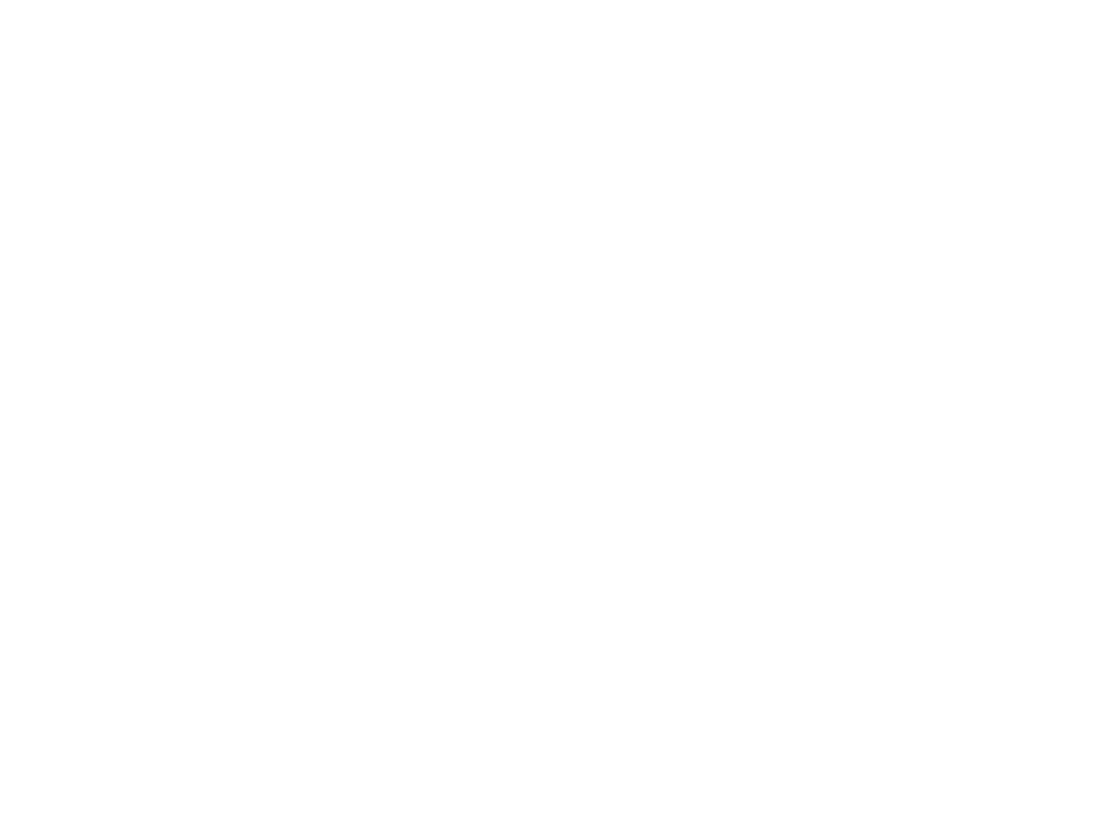

In [13]:
%matplotlib notebook
sort_array = [ item for sublist in [ (x, x+10) for x in range(0,10)] for item in sublist ][::-1]
sort_array.insert(0,20)
sns.heatmap(pd.DataFrame(features).sort_values(by=sort_array))

# Preenchimento com média

Considerando os valores desconhecidos, podemos particionar o *heatmap* em quatro regiões, delimitadas pelo eixo horizontal definido pela coluna 20 e pelo eixo vertical entre valores de $X_{a,m}$ e $Y_{a,m}$ que está entre as colunas 9 e 10. 

Então atribuímos a cada célula de valor desconhecido o valor médio da sua região.

In [14]:
nan_values = []
for i,v in enumerate(features):
    for j,k in enumerate(v):
        if math.isnan(features[i][j]):
            nan_values.append((i,j, features[i][-1]))
    
good_student_prob = []
bad_student_prob = []
good_student_grade = []
bad_student_grade = []
for i,v in enumerate(features):
    for j,k in enumerate(v[0:-1]):
        if features[i][-1] == 0:
            if j < 10:
                bad_student_prob.append(features[i][j])
            else:
                bad_student_grade.append(features[i][j])
        elif features[i][-1] == 1:
            if j < 10:
                good_student_prob.append(features[i][j])
            else:
                good_student_grade.append(features[i][j])
                
remove_nan = lambda x: [z for z in x if not math.isnan(z)]
good_student_prob_mean = np.mean(remove_nan(good_student_prob))
bad_student_prob_mean = np.mean(remove_nan(bad_student_prob))
good_student_grade_mean = np.mean(remove_nan(good_student_grade))
bad_student_grade_mean = np.mean(remove_nan(bad_student_grade))

for i,v in enumerate(features):
    for j,k in enumerate(v[0:-1]):
        if features[i][-1] == 0:
            if j < 10 and math.isnan(features[i][j]):
                features[i][j] = bad_student_prob_mean
            elif math.isnan(features[i][j]):
                features[i][j] = bad_student_grade_mean
        elif features[i][-1] == 1:
            if j < 10 and math.isnan(features[i][j]):
                features[i][j] = good_student_prob_mean
            elif math.isnan(features[i][j]):
                features[i][j] = good_student_grade_mean
                
sort_array = [ item for sublist in [ (x, x+10) for x in range(0,10)] for item in sublist ][::-1]
sort_array.insert(0,20)
sns.heatmap(pd.DataFrame(features).sort_values(by=sort_array))

In [15]:
pd.DataFrame(features).dropna().to_csv('dataset_preenchido.csv', index=False)

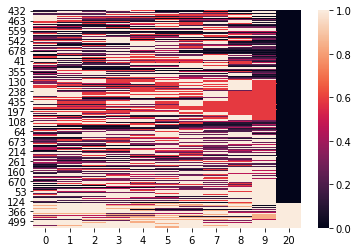

In [68]:
%matplotlib inline

sns.heatmap(pd.DataFrame(features)\
            .dropna()\
            .sort_values(by=sort_array)\
            [[0,1,2,3,4,5,6,7,8,9,20]])

In [17]:
disciplinas['nome_componente'].reset_index()[['nome_componente']]

,nome_componente
0,CÁLCULO 1
1,LÓGICA MATEMÁTICA
2,MATEMÁTICA DISCRETA
3,FÍSICA PARA COMPUTAÇÃO
4,ÁLGEBRA LINEAR
5,CÁLCULO 2
6,PROGRAMAÇÃO DE COMPUTADORES 2 CN
7,SISTEMAS DIGITAIS
8,INTRODUÇÃO À COMPUTAÇÃO
9,PROGRAMAÇÃO DE COMPUTADORES 1 CN


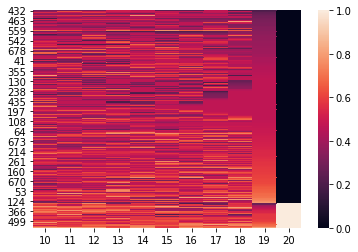

In [69]:
sns.heatmap(pd.DataFrame(features)\
            .dropna()\
            .sort_values(by=sort_array)\
            [[10,11,12,13,14,15,16,17,18,19,20]])

In [19]:
legend = disciplinas['nome_componente'].reset_index()[['nome_componente']]
legend.index = legend.index + 10
legend

,nome_componente
10,CÁLCULO 1
11,LÓGICA MATEMÁTICA
12,MATEMÁTICA DISCRETA
13,FÍSICA PARA COMPUTAÇÃO
14,ÁLGEBRA LINEAR
15,CÁLCULO 2
16,PROGRAMAÇÃO DE COMPUTADORES 2 CN
17,SISTEMAS DIGITAIS
18,INTRODUÇÃO À COMPUTAÇÃO
19,PROGRAMAÇÃO DE COMPUTADORES 1 CN


In [ ]:
pd.DataFrame(features).dropna().to_csv('dataset_preenchido_reduzido.csv', index=False)